<a href="https://colab.research.google.com/github/AlaaIraqy/JawSegmentation/blob/main/atomica_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jaws Segmentation Task

Hello, You're tasked with building a neural network using pytorch which segments upper (Maxilla) and lower(Mandible) jaws in a DICOM file

The Dataset is provided as 2D slices from all 3 orthogonal points of view Axial, Coronal, and Sagittal, if you're not familiar with what a DICOM is, you're expected to read online about it

Duration: 1 Week

Deliverables: This notebook (which should contain your solution), and any other files (like saved weights) in a **zip** file, and you mail this **zip** file to us

In [1]:
! pip install --user torch torchvision matplotlib numpy progressbar

In [2]:
import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2

In [3]:
LOCAL_DATASET_PATH = 'dataset'
BATCH_SIZE = 16
AXIAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip'
AXIAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip'
CORONAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip'
CORONAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip'
SAGITTAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip'
SAGITTAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip'

## Downloading Dataset

In this part we download the publicly available dataset, you can skip it if you already have it, it should be 5.6 Gb worth of data

In [4]:
# download_progress_bar = None
# def show_progress(block_num, block_size, total_size):
#     global download_progress_bar
#     if download_progress_bar is None:
#         download_progress_bar = progressbar.ProgressBar(maxval=total_size)
#         download_progress_bar.start()

#     downloaded = block_num * block_size
#     if downloaded < total_size:
#         download_progress_bar.update(downloaded)
#     else:
#         download_progress_bar.finish()
#         download_progress_bar = None

# def download_file(url, disk_path):
#     print(f'downloading {url}')
#     filename, _ = urllib.request.urlretrieve(url, reporthook=show_progress)
#     os.makedirs(disk_path)
#     with zipfile.ZipFile(filename, 'r') as zip:
#         zip.extractall(disk_path)

# def download_data(to=LOCAL_DATASET_PATH):
#     download_file(AXIAL_TRAINING_DATASET, os.path.join(to, 'axial', 'train'))
#     download_file(AXIAL_TESTING_DATASET, os.path.join(to, 'axial', 'test'))
#     download_file(CORONAL_TRAINING_DATASET, os.path.join(to, 'coronal', 'train'))
#     download_file(CORONAL_TESTING_DATASET, os.path.join(to, 'coronal', 'test'))
#     download_file(SAGITTAL_TRAINING_DATASET, os.path.join(to, 'sagittal', 'train'))
#     download_file(SAGITTAL_TESTING_DATASET, os.path.join(to, 'sagittal', 'test'))

# download_data()

## Explore The Dataset

In this section you should explore/plot the dataset and get familiar with it, we are nice enough to write a dataset loader for you and we did some initial visualization for you

In [4]:
class JawsDataset(torch.utils.data.Dataset):
	def __init__(self, dicom_file_list, transforms):
		self.dicom_file_list = dicom_file_list
		self.transforms = transforms

	def __len__(self):
		return len(self.dicom_file_list)

	def __getitem__(self, idx):
		dicom_path = self.dicom_file_list[idx]
		label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
		dicom_file = gzip.GzipFile(dicom_path, 'rb')
		dicom = np.load(dicom_file)
		label_file = gzip.GzipFile(label_path, 'rb')
		label = np.load(label_file)
		return self.transforms(dicom), self.transforms(label)

def axial_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/axial/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def coronal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/coronal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def sagittal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def axial_dataset_test(transforms):
	files = glob.glob('dataset/axial/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def coronal_dataset_test(transforms):
	files = glob.glob('dataset/coronal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def sagittal_dataset_test(transforms):
	files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)


In [5]:
dataset_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])

In [6]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train(dataset_transforms)
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(dataset_transforms)
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(dataset_transforms)
print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')

axial_train_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
axial_validation_loader = torch.utils.data.DataLoader(axial_validatiaon_dataset, shuffle=False, batch_size=BATCH_SIZE)
coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 5043 slice
coronal training dataset: 7277 slice
sagittal training dataset: 7277 slice


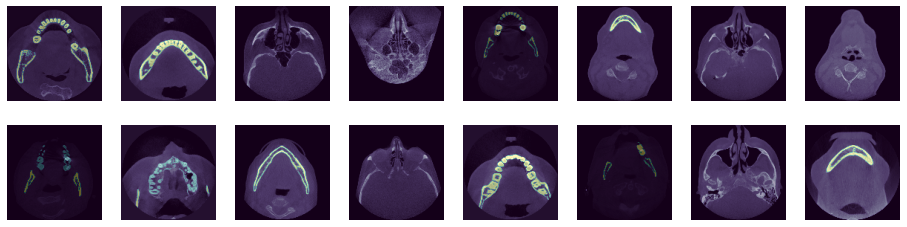

In [7]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
plt.figure(figsize=(16, 4))

for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

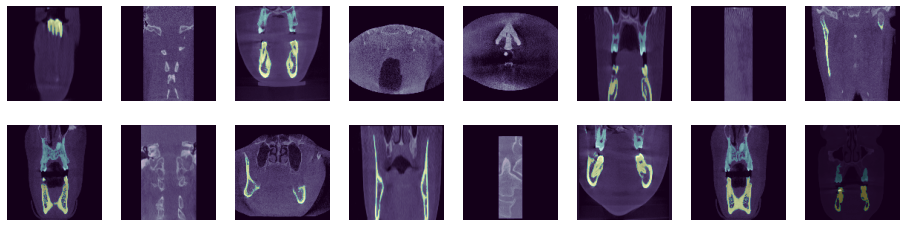

In [8]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

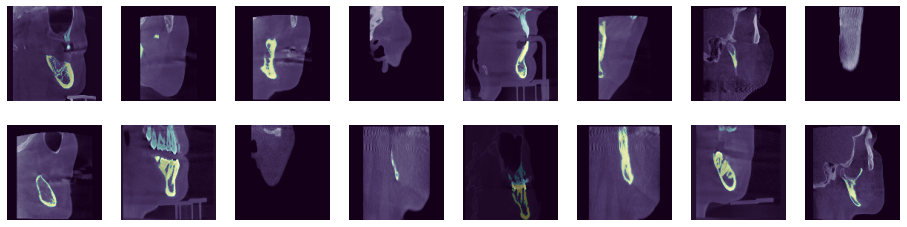

In [9]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

Loading data into np arrays

In [10]:
axial_train_dataset = np.array(axial_train_dataset)
print(axial_train_dataset.shape)
coronal_train_dataset = np.array(coronal_train_dataset)
print(coronal_train_dataset.shape)
sagittal_train_dataset = np.array(sagittal_train_dataset)
print(sagittal_train_dataset.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(5043, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing im

(7277, 2)
(7277, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


(128, 128)
(128, 128)
(128, 128)


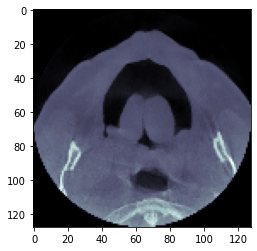

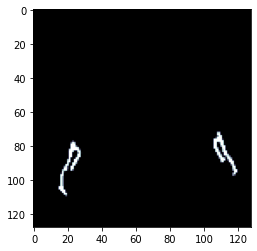

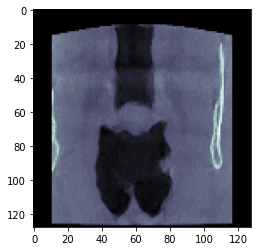

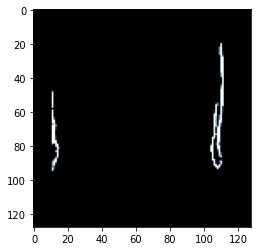

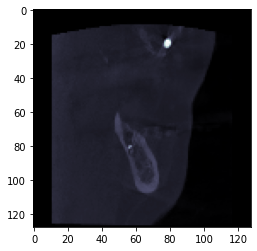

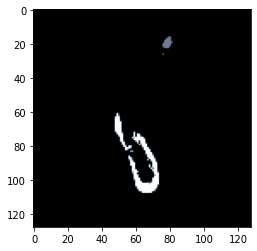

In [11]:
axial_train_images=[]
axial_ground_truth=[]
axial_val_images=[]
axial_val_ground_truth=[]
for i in range(4043):
  axial_train_images.append(axial_train_dataset[i][0].numpy())
  axial_ground_truth.append(axial_train_dataset[i][1].numpy())
for i in range(4043):
  axial_train_images[i]=axial_train_images[i][0]
  axial_ground_truth[i]=axial_ground_truth[i][0]
plt.figure(figsize=(16, 4))
plt.imshow(axial_train_images[0].squeeze(), cmap='bone')
plt.figure(figsize=(16, 4))
plt.imshow(axial_ground_truth[0].squeeze(), cmap='bone')
for i in range(4042,5043):
  axial_val_images.append(axial_train_dataset[i][0].numpy())
  axial_val_ground_truth.append(axial_train_dataset[i][1].numpy())
for i in range(1001):
  axial_val_images[i]=axial_val_images[i][0]
  axial_val_ground_truth[i]=axial_val_ground_truth[i][0]
axial_train_images=np.array(axial_train_images)
axial_ground_truth=np.array(axial_ground_truth)
axial_val_images=np.array(axial_val_images)
axial_val_ground_truth=np.array(axial_val_ground_truth)



coronal_train_images=[]
coronal_ground_truth=[]
coronal_val_images=[]
coronal_val_ground_truth=[]
for i in range(6277):
  coronal_train_images.append(coronal_train_dataset[i][0].numpy())
  coronal_ground_truth.append(coronal_train_dataset[i][1].numpy())
for i in range(6277):
  coronal_train_images[i]=coronal_train_images[i][0]
  coronal_ground_truth[i]=coronal_ground_truth[i][0]
plt.figure(figsize=(16, 4))
plt.imshow(coronal_train_images[0].squeeze(), cmap='bone')
plt.figure(figsize=(16, 4))
plt.imshow(coronal_ground_truth[0].squeeze(), cmap='bone')
for i in range(6276,7277):
  coronal_val_images.append(coronal_train_dataset[i][0].numpy())
  coronal_val_ground_truth.append(coronal_train_dataset[i][1].numpy())
for i in range(1001):
  coronal_val_images[i]=coronal_val_images[i][0]
  coronal_val_ground_truth[i]=coronal_val_ground_truth[i][0]
coronal_train_images=np.array(coronal_train_images)
coronal_ground_truth=np.array(coronal_ground_truth)
coronal_val_images=np.array(coronal_val_images)
coronal_val_ground_truth=np.array(coronal_val_ground_truth)



sagittal_train_images=[]
sagittal_ground_truth=[]
sagittal_val_images=[]
sagittal_val_ground_truth=[]
for i in range(6277):
  sagittal_train_images.append(sagittal_train_dataset[i][0].numpy())
  sagittal_ground_truth.append(sagittal_train_dataset[i][1].numpy())
for i in range(6277):
  sagittal_train_images[i]=sagittal_train_images[i][0]
  sagittal_ground_truth[i]=sagittal_ground_truth[i][0]
plt.figure(figsize=(16, 4))
plt.imshow(sagittal_train_images[0].squeeze(), cmap='bone')
plt.figure(figsize=(16, 4))
plt.imshow(sagittal_ground_truth[0].squeeze(), cmap='bone')
for i in range(6276,7277):
  sagittal_val_images.append(sagittal_train_dataset[i][0].numpy())
  sagittal_val_ground_truth.append(sagittal_train_dataset[i][1].numpy())
for i in range(1001):
  sagittal_val_images[i]=sagittal_val_images[i][0]
  sagittal_val_ground_truth[i]=sagittal_val_ground_truth[i][0]
sagittal_train_images=np.array(sagittal_train_images)
sagittal_ground_truth=np.array(sagittal_ground_truth)
sagittal_val_images=np.array(sagittal_val_images)
sagittal_val_ground_truth=np.array(sagittal_val_ground_truth)


print(axial_train_images[0].shape)
print(coronal_train_images[0].shape)
print(sagittal_train_images[0].shape)


## Training

Now that you have downloaded the dataset and inspected it for a bit, you should train your model here, you can train a single model which works with all views (axial, sagittal, coronal), or you can train a model each, it's up to you



>Implementing Unet



In [12]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import os
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Conv2DTranspose, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import RMSprop,Adam


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(filters=1, kernel_size=(1,1), padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model
if __name__ == "__main__":
    input_shape = (128, 128, 1)
    model = build_unet(input_shape)
    model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

Loss and metrics

In [13]:
from keras import backend as K
from sklearn.metrics import confusion_matrix  

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

Building and training model

In [15]:
#Axial training
AxialModel=model
AxialModel.compile(loss=[jaccard_distance],
                   optimizer=Adam(learning_rate=1e-5),
                   metrics=[iou])

result = AxialModel.fit(axial_train_images.astype(np.float32),axial_ground_truth.astype(np.float32),
                    validation_data=(axial_val_images.astype(np.float32), axial_val_ground_truth.astype(np.float32)),
                    batch_size=16,
                    epochs=10,
                    verbose=1)
AxialModel.save('/content/axial model')

Epoch 1/10
253/253 [==============================] - 152s 529ms/step - loss: 0.1249 - iou: 0.8751 - val_loss: 0.0824 - val_iou: 0.9176
Epoch 2/10
253/253 [==============================] - 124s 491ms/step - loss: 0.0501 - iou: 0.9499 - val_loss: 0.0383 - val_iou: 0.9617
Epoch 3/10
253/253 [==============================] - 124s 491ms/step - loss: 0.0384 - iou: 0.9616 - val_loss: 0.0302 - val_iou: 0.9698
Epoch 4/10
253/253 [==============================] - 124s 490ms/step - loss: 0.0338 - iou: 0.9662 - val_loss: 0.0268 - val_iou: 0.9732
Epoch 5/10
253/253 [==============================] - 124s 490ms/step - loss: 0.0312 - iou: 0.9688 - val_loss: 0.0247 - val_iou: 0.9753
Epoch 6/10
253/253 [==============================] - 125s 496ms/step - loss: 0.0296 - iou: 0.9704 - val_loss: 0.0232 - val_iou: 0.9768
Epoch 7/10
253/253 [==============================] - 124s 491ms/step - loss: 0.0284 - iou: 0.9716 - val_loss: 0.0220 - val_iou: 0.9780
Epoch 8/10
253/253 [============================

In [17]:
#coronal training
CoronalModel=model

CoronalModel.compile(loss=[jaccard_distance],
                   optimizer=Adam(learning_rate=1e-5),
                   metrics=[iou])

CoronalResult = CoronalModel.fit(coronal_train_images.astype(np.float32),coronal_ground_truth.astype(np.float32),
                    validation_data=(coronal_val_images.astype(np.float32), coronal_val_ground_truth.astype(np.float32)),
                    batch_size=16,
                    epochs=10,
                    verbose=1)
CoronalModel.save('/content/coronal model')

Epoch 1/10
393/393 [==============================] - 197s 493ms/step - loss: 0.0258 - iou: 0.9742 - val_loss: 0.0237 - val_iou: 0.9763
Epoch 2/10
393/393 [==============================] - 188s 478ms/step - loss: 0.0230 - iou: 0.9770 - val_loss: 0.0210 - val_iou: 0.9790
Epoch 3/10
393/393 [==============================] - 188s 478ms/step - loss: 0.0222 - iou: 0.9778 - val_loss: 0.0204 - val_iou: 0.9796
Epoch 4/10
393/393 [==============================] - 188s 478ms/step - loss: 0.0211 - iou: 0.9789 - val_loss: 0.0196 - val_iou: 0.9804
Epoch 5/10
393/393 [==============================] - 188s 478ms/step - loss: 0.0205 - iou: 0.9795 - val_loss: 0.0193 - val_iou: 0.9807
Epoch 6/10
393/393 [==============================] - 188s 478ms/step - loss: 0.0200 - iou: 0.9800 - val_loss: 0.0194 - val_iou: 0.9806
Epoch 7/10
393/393 [==============================] - 188s 478ms/step - loss: 0.0196 - iou: 0.9804 - val_loss: 0.0184 - val_iou: 0.9816
Epoch 8/10
393/393 [============================

In [15]:
#sagittal training
SagittalModel=model

SagittalModel.compile(loss=[jaccard_distance],
                   optimizer=Adam(learning_rate=1e-5),
                   metrics=[iou])

SagittalResult = SagittalModel.fit(sagittal_train_images.astype(np.float32),sagittal_ground_truth.astype(np.float32),
                    validation_data=(sagittal_val_images.astype(np.float32), sagittal_val_ground_truth.astype(np.float32)),
                    batch_size=16,
                    epochs=10,
                    verbose=1)
SagittalModel.save('/content/sagittal model')

Epoch 1/10
393/393 [==============================] - 215s 499ms/step - loss: 0.0848 - iou: 0.9152 - val_loss: 0.0445 - val_iou: 0.9555
Epoch 2/10
393/393 [==============================] - 188s 479ms/step - loss: 0.0343 - iou: 0.9657 - val_loss: 0.0291 - val_iou: 0.9709
Epoch 3/10
393/393 [==============================] - 188s 479ms/step - loss: 0.0284 - iou: 0.9716 - val_loss: 0.0266 - val_iou: 0.9734
Epoch 4/10
393/393 [==============================] - 188s 479ms/step - loss: 0.0260 - iou: 0.9740 - val_loss: 0.0257 - val_iou: 0.9743
Epoch 5/10
393/393 [==============================] - 188s 478ms/step - loss: 0.0245 - iou: 0.9755 - val_loss: 0.0229 - val_iou: 0.9771
Epoch 6/10
393/393 [==============================] - 189s 482ms/step - loss: 0.0234 - iou: 0.9766 - val_loss: 0.0220 - val_iou: 0.9780
Epoch 7/10
393/393 [==============================] - 188s 480ms/step - loss: 0.0225 - iou: 0.9775 - val_loss: 0.0217 - val_iou: 0.9783
Epoch 8/10
393/393 [============================

## Testing

Now you should run your trained model on the test dataset available below and report your results

axial testing dataset: 1450 slice
coronal testing dataset: 2348 slice
sagittal testing dataset: 2448 slice


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


(1450, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


(2348, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(2448, 2)
(128, 128)
(128, 128)
(128, 128)


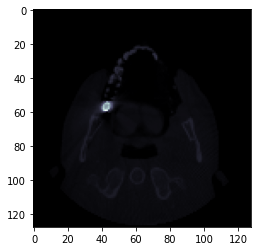

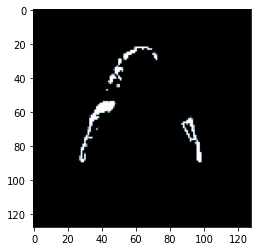

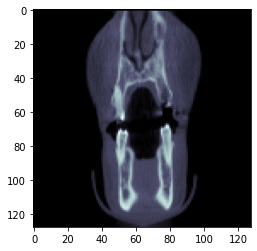

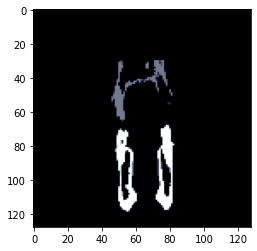

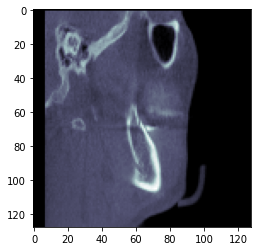

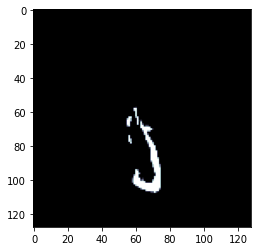

In [16]:
axial_test_dataset = axial_dataset_test(dataset_transforms)
coronal_test_dataset = coronal_dataset_test(dataset_transforms)
sagittal_test_dataset = sagittal_dataset_test(dataset_transforms)
print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_test_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_test_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)


axial_test_dataset = np.array(axial_test_dataset)
print(axial_test_dataset.shape)
coronal_test_dataset = np.array(coronal_test_dataset)
print(coronal_test_dataset.shape)
sagittal_test_dataset = np.array(sagittal_test_dataset)
print(sagittal_test_dataset.shape)


axial_test_images=[]
axial_test_ground_truth=[]
for i in range(1450):
  axial_test_images.append(axial_test_dataset[i][0].numpy())
  axial_test_ground_truth.append(axial_test_dataset[i][1].numpy())
for i in range(1450):
  axial_test_images[i]=axial_test_images[i][0]
  axial_test_ground_truth[i]=axial_test_ground_truth[i][0]
plt.figure(figsize=(16, 4))
plt.imshow(axial_test_images[0].squeeze(), cmap='bone')
plt.figure(figsize=(16, 4))
plt.imshow(axial_test_ground_truth[0].squeeze(), cmap='bone')

axial_test_images=np.array(axial_test_images)
axial_test_ground_truth=np.array(axial_test_ground_truth)




coronal_test_images=[]
coronal_test_ground_truth=[]
for i in range(2348):
  coronal_test_images.append(coronal_test_dataset[i][0].numpy())
  coronal_test_ground_truth.append(coronal_test_dataset[i][1].numpy())
for i in range(2348):
  coronal_test_images[i]=coronal_test_images[i][0]
  coronal_test_ground_truth[i]=coronal_test_ground_truth[i][0]
plt.figure(figsize=(16, 4))
plt.imshow(coronal_test_images[0].squeeze(), cmap='bone')
plt.figure(figsize=(16, 4))
plt.imshow(coronal_test_ground_truth[0].squeeze(), cmap='bone')

coronal_test_images=np.array(coronal_test_images)
coronal_test_ground_truth=np.array(coronal_test_ground_truth)



sagittal_test_images=[]
sagittal_test_ground_truth=[]
for i in range(2448):
  sagittal_test_images.append(sagittal_test_dataset[i][0].numpy())
  sagittal_test_ground_truth.append(sagittal_test_dataset[i][1].numpy())
for i in range(2448):
  sagittal_test_images[i]=sagittal_test_images[i][0]
  sagittal_test_ground_truth[i]=sagittal_test_ground_truth[i][0]
plt.figure(figsize=(16, 4))
plt.imshow(sagittal_test_images[0].squeeze(), cmap='bone')
plt.figure(figsize=(16, 4))
plt.imshow(sagittal_test_ground_truth[0].squeeze(), cmap='bone')

sagittal_test_images=np.array(sagittal_test_images)
sagittal_test_ground_truth=np.array(sagittal_test_ground_truth)


print(axial_test_images[0].shape)
print(coronal_test_images[0].shape)
print(sagittal_test_images[0].shape)

visualizing some test cases for axial model

Text(0.5, 1.0, 'ground truth')

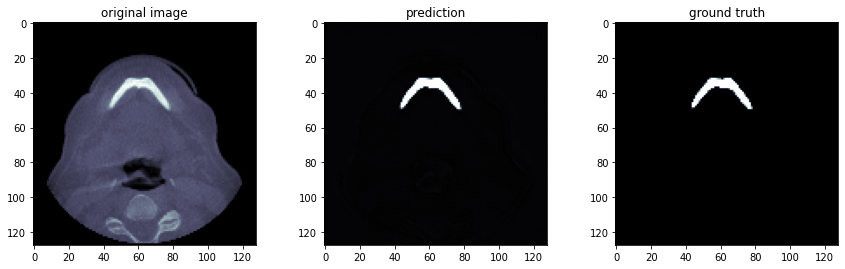

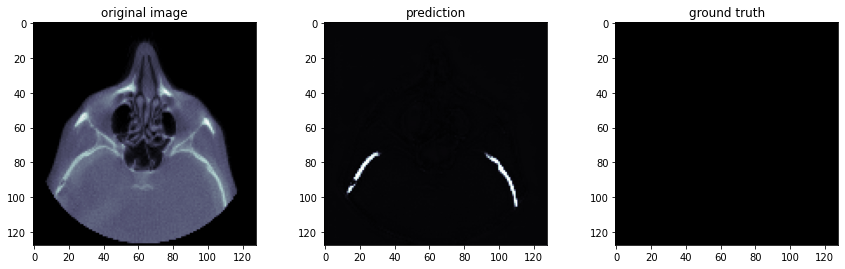

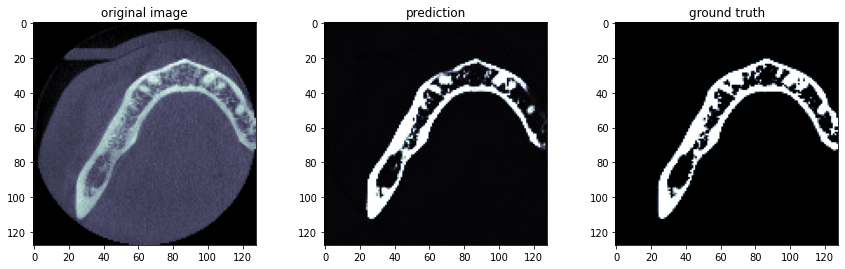

In [22]:
idx1=470
idx2=1
idx3=1400
prediction = np.array(AxialModel.predict(axial_test_images))
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(axial_test_images[idx1].squeeze(), cmap='bone')
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(prediction[idx1].squeeze(), cmap='bone')
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(axial_test_ground_truth[idx1].squeeze(), cmap='bone')
plt.title("ground truth")

plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(axial_test_images[idx2].squeeze(), cmap='bone')
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(prediction[idx2].squeeze(), cmap='bone')
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(axial_test_ground_truth[idx2].squeeze(), cmap='bone')
plt.title("ground truth")

plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(axial_test_images[idx3].squeeze(), cmap='bone')
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(prediction[idx3].squeeze(), cmap='bone')
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(axial_test_ground_truth[idx3].squeeze(), cmap='bone')
plt.title("ground truth")

 Evaluating axial model on test set

In [23]:
AxialModelResults = AxialModel.evaluate(axial_test_images, axial_test_ground_truth.astype(np.float32), batch_size= 16)
print('____________stats on test____________')
print('IOU:       |   {:.2f}  |'.format(AxialModelResults[1]*100))
print("Loss:      |   {:.2f}  |".format(AxialModelResults[0]*100))

91/91 [==============================] - 13s 146ms/step - loss: 0.0286 - iou: 0.9714
____________stats on test____________
IOU:       |   97.14  |
Loss:      |   2.86  |


visualizing some test cases for coronal model

Text(0.5, 1.0, 'ground truth')

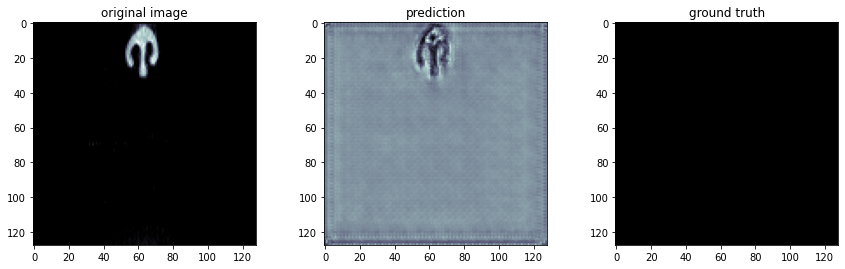

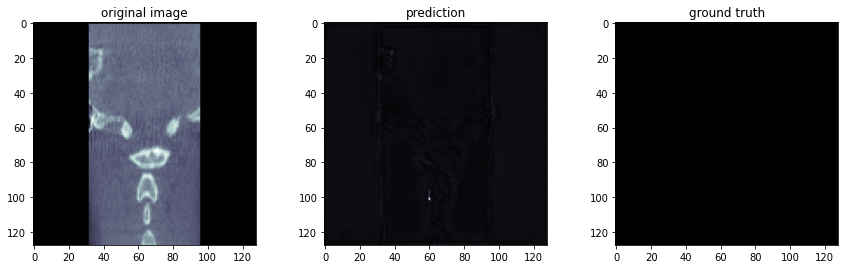

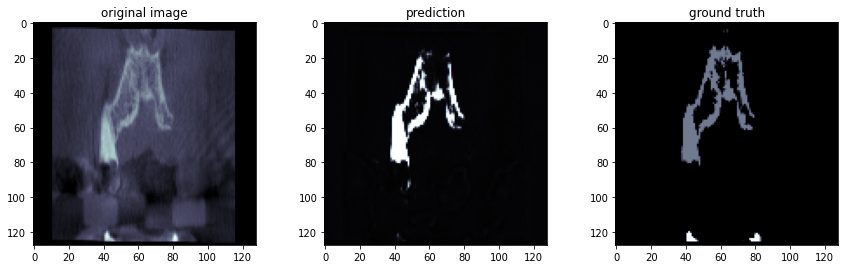

In [25]:
idx1=470
idx2=1
idx3=1400
Coronalprediction = np.array(CoronalModel.predict(coronal_test_images))
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(coronal_test_images[idx1].squeeze(), cmap='bone')
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(Coronalprediction[idx1].squeeze(), cmap='bone')
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(coronal_test_ground_truth[idx1].squeeze(), cmap='bone')
plt.title("ground truth")

plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(coronal_test_images[idx2].squeeze(), cmap='bone')
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(Coronalprediction[idx2].squeeze(), cmap='bone')
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(coronal_test_ground_truth[idx2].squeeze(), cmap='bone')
plt.title("ground truth")

plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(coronal_test_images[idx3].squeeze(), cmap='bone')
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(Coronalprediction[idx3].squeeze(), cmap='bone')
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(coronal_test_ground_truth[idx3].squeeze(), cmap='bone')
plt.title("ground truth")

Evaluating coronal model on test set

In [ ]:
CoronalModel = keras.models.load_model('/content/coronal model')
CoronalModelResults = CoronalModel.evaluate(coronal_test_images, coronal_test_ground_truth.astype(np.float32), batch_size= 16)
print('____________stats on test____________')
print('IOU:       |   {:.2f}  |'.format(CoronalModelResults[1]*100))
print("Loss:      |   {:.2f}  |".format(CoronalModelResults[0]*100))

visualizing some test cases for sagittal model

Text(0.5, 1.0, 'ground truth')

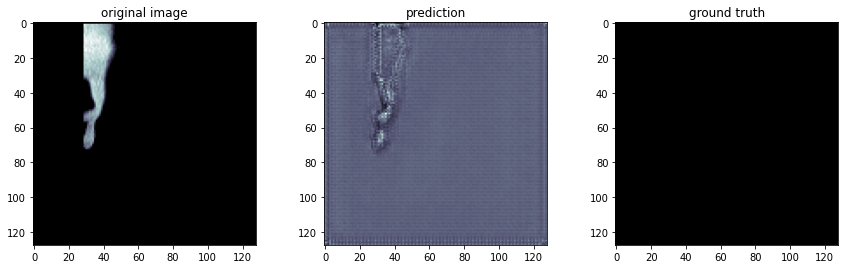

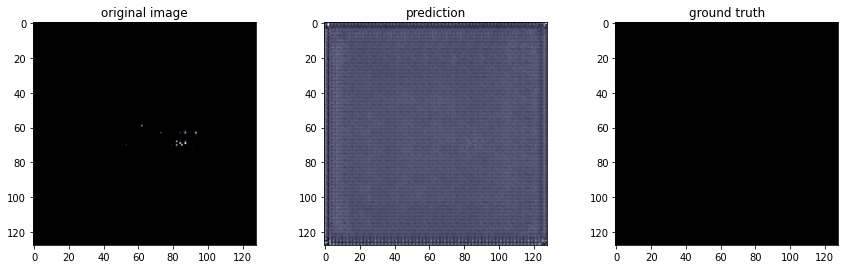

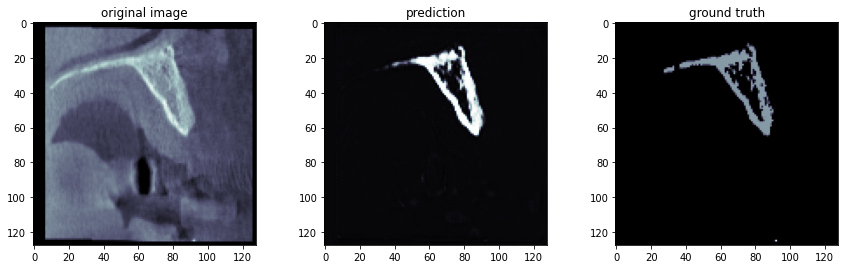

In [20]:
idx1=470
idx2=1
idx3=1400
Sagittalprediction = np.array(SagittalModel.predict(sagittal_test_images))
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(sagittal_test_images[idx1].squeeze(), cmap='bone')
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(Sagittalprediction[idx1].squeeze(), cmap='bone')
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(sagittal_test_ground_truth[idx1].squeeze(), cmap='bone')
plt.title("ground truth")

plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(sagittal_test_images[idx2].squeeze(), cmap='bone')
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(Sagittalprediction[idx2].squeeze(), cmap='bone')
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(sagittal_test_ground_truth[idx2].squeeze(), cmap='bone')
plt.title("ground truth")

plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(sagittal_test_images[idx3].squeeze(), cmap='bone')
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(Sagittalprediction[idx3].squeeze(), cmap='bone')
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(sagittal_test_ground_truth[idx3].squeeze(), cmap='bone')
plt.title("ground truth")

Evaluating sagittal model on test set

In [21]:
SagittalModelResults = SagittalModel.evaluate(sagittal_test_images, sagittal_test_ground_truth.astype(np.float32), batch_size= 16)
print('____________stats on test____________')
print('IOU:       |   {:.2f}  |'.format(SagittalModelResults[1]*100))
print("Loss:      |   {:.2f}  |".format(SagittalModelResults[0]*100))

153/153 [==============================] - 23s 147ms/step - loss: 0.0236 - iou: 0.9764
____________stats on test____________
IOU:       |   97.64  |
Loss:      |   2.36  |
